In [3]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# build soma (starter parameters)
soma = h.Section(name='soma')
soma.L = soma.diam = 20  # µm
soma.Ra = 100            # ohm·cm
soma.cm = 1              # µF/cm2

# passive + Hodgkin-Huxley channels
soma.insert('pas')
soma.e_pas = -65
soma.g_pas = 1e-4
soma.insert('hh') 

soma

In [4]:
# -------------------------
# Stimulus and recording
# -------------------------
# IClamp in point-process units (nA)
stim_amp_nA = 0.2
stim_delay = 5.0
stim_dur = 0.5
tstop = 40.0

ic = h.IClamp(soma(0.5))
ic.delay = stim_delay
ic.dur = stim_dur
ic.amp = stim_amp_nA

# NEURON Vectors for recording
tvec = h.Vector()
vvec = h.Vector()
ina_vec = h.Vector()
ik_vec = h.Vector()

tvec.record(h._ref_t)
vvec.record(soma(0.5)._ref_v)
ina_vec.record(soma(0.5)._ref_ina)  # mA/cm2
ik_vec.record(soma(0.5)._ref_ik)    # mA/cm2

m_vec = h.Vector()
h_vec = h.Vector()
n_vec = h.Vector()

m_vec.record(soma(0.5)._ref_m_hh)
h_vec.record(soma(0.5)._ref_h_hh)
n_vec.record(soma(0.5)._ref_n_hh)

# -------------------------
# Run
# -------------------------
h.tstop = tstop
h.finitialize(soma.e_pas)
h.run()

# -------------------------
# Convert recorded data -> numpy and convert units
# -------------------------
t = np.array(tvec)
V = np.array(vvec)
ina_density = np.array(ina_vec)  # mA/cm2
ik_density = np.array(ik_vec)    # mA/cm2

# area in µm^2
area_um2 = soma(0.5).area()
# conversion factor: mA/cm2 * area(um2) * 1e-2 -> nA
conv = area_um2 * 1e-2
Ina_nA = ina_density * conv
Ik_nA = ik_density * conv 

In [9]:
# -------------------------
# Convert recorded data -> numpy and convert units
# -------------------------
t = np.array(tvec)
V = np.array(vvec)
ina_density = np.array(ina_vec)  # mA/cm2
ik_density = np.array(ik_vec)    # mA/cm2

# area in µm^2
area_um2 = soma(0.5).area()
# conversion factor: mA/cm2 * area(um2) * 1e-2 -> nA
conv = area_um2 * 1e-2
Ina_nA = ina_density * conv
Ik_nA = ik_density * conv

m = np.array(m_vec)
h_gate = np.array(h_vec)
n = np.array(n_vec)

In [10]:
# -------------------------
# Plotting function (only plotting is inside a function)
# -------------------------
def plot_ap_and_currents(t, V, Ina_nA, Ik_nA, title=None):
    """
    Produce a 3-panel plot:
      top: membrane potential (mV)
      middle: Na current (nA)  [note: inward is negative]
      bottom: K current (nA)
    Inputs:
      t       : 1D array (ms)
      V       : membrane potential (mV)
      Ina_nA  : Na total current (nA)
      Ik_nA   : K total current (nA)
      title   : optional figure title
    """
    fig, (ax_v, ax_na, ax_k) = plt.subplots(3, 1, figsize=(8, 8), sharex=True,
                                            gridspec_kw={'height_ratios': [2, 1, 1]})

    ax_v.plot(t, V, color='k')
    ax_v.set_ylabel('V (mV)')
    if title is None:
        title = f'HH AP (IClamp {stim_amp_nA} nA, delay {stim_delay} ms, dur {stim_dur} ms)'
    ax_v.set_title(title)

    ax_na.plot(t, Ina_nA, color='b')
    ax_na.set_ylabel('I_Na (nA)')
    ax_na.axhline(0.0, color='gray', lw=0.5)
    # mark peak inward (most negative) Na
    idx_min = np.argmin(Ina_nA)
    ax_na.plot(t[idx_min], Ina_nA[idx_min], 'ro')
    ax_na.text(t[idx_min], Ina_nA[idx_min],
               f' min={Ina_nA[idx_min]:.3g} nA\n t={t[idx_min]:.1f} ms',
               va='bottom', color='r')

    ax_k.plot(t, Ik_nA, color='orange')
    ax_k.set_ylabel('I_K (nA)')
    ax_k.set_xlabel('time (ms)')
    ax_k.axhline(0.0, color='gray', lw=0.5)
    # mark peak outward K
    idx_max = np.argmax(Ik_nA)
    ax_k.plot(t[idx_max], Ik_nA[idx_max], 'ro')
    ax_k.text(t[idx_max], Ik_nA[idx_max],
              f' max={Ik_nA[idx_max]:.3g} nA\n t={t[idx_max]:.1f} ms',
              va='bottom', color='r')

    plt.tight_layout()
    plt.show()

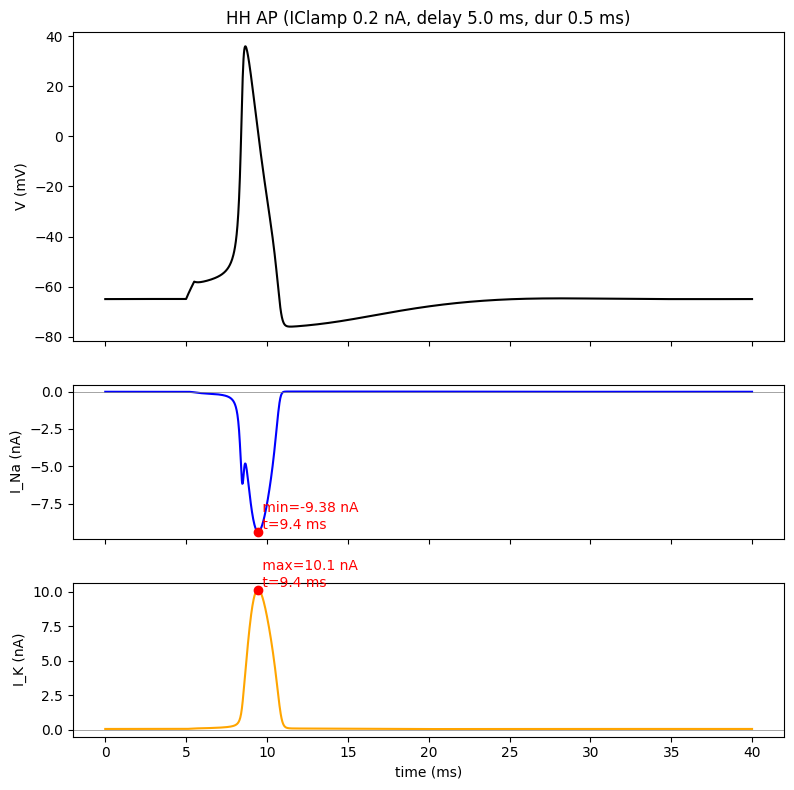

In [11]:
# -------------------------
# Produce the plot (call the plotting function)
# -------------------------
if __name__ == '__main__':
    plot_ap_and_currents(t, V, Ina_nA, Ik_nA)


In [12]:
def plot_vm_and_gating(t, V, m, h_gate, n, title=None):
    """
    Plot membrane potential and HH gating variables vs time.
    Inputs:
      t       : 1D array (ms)
      V       : membrane potential (mV)
      m       : activation variable m (unitless, 0..1)
      h_gate  : inactivation variable h (unitless, 0..1)
      n       : K activation variable n (unitless, 0..1)
    Returns: (fig, axes)
    """
    fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True,
                             gridspec_kw={'height_ratios': [2, 1, 1, 1]})
    ax_v, ax_m, ax_h, ax_n = axes

    ax_v.plot(t, V, color='k')
    ax_v.set_ylabel('V (mV)')
    if title:
        ax_v.set_title(title)

    ax_m.plot(t, m, color='C0')
    ax_m.set_ylabel('m')
    ax_m.set_ylim(-0.05, 1.05)

    ax_h.plot(t, h_gate, color='C1')
    ax_h.set_ylabel('h')
    ax_h.set_ylim(-0.05, 1.05)

    ax_n.plot(t, n, color='C2')
    ax_n.set_ylabel('n')
    ax_n.set_ylim(-0.05, 1.05)
    ax_n.set_xlabel('time (ms)')

    for ax in axes:
        ax.grid(True, linestyle=':', linewidth=0.5)

    plt.tight_layout()
    plt.show()
    return fig, axes


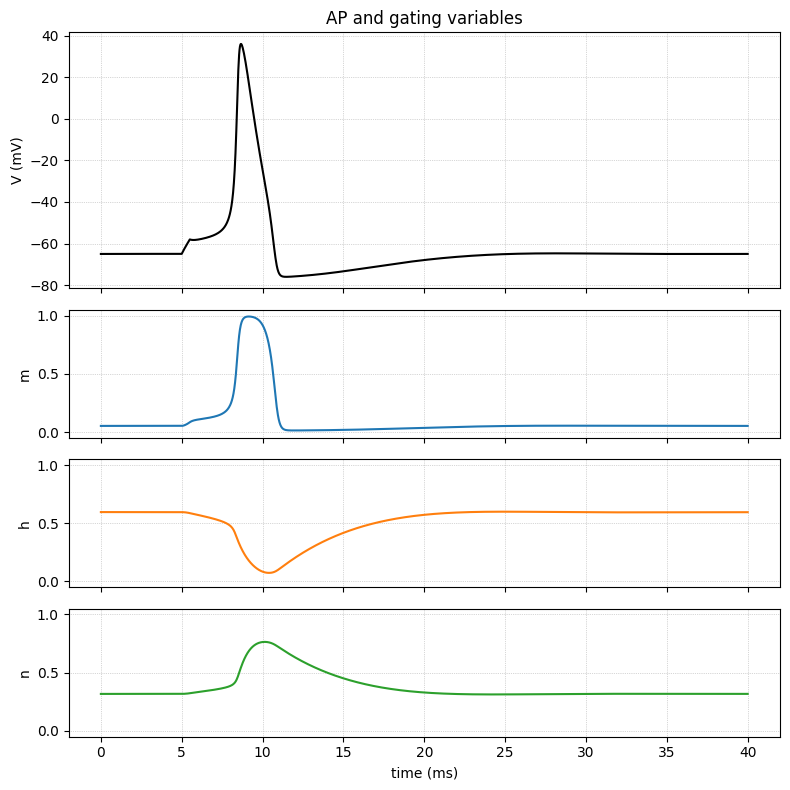

In [13]:
fig, axes = plot_vm_and_gating(t, V, m, h_gate, n, title='AP and gating variables')